# Chapter 3 - Deep Dive into Attention Mechanisms 

This notebook teaches and tests LLMs from Scratch Chapter 3 concepts (attention, casual masking, multi-head) with clean Pytorch. 
It builds off of chapter 2 and provides a detailed exploration of attention mechanisms in transformers. 

## Chapter 2 Working with Text Data (recap)

* **Tokenization:** We split raw text into tokens using rules like byte‑pair encoding (BPE).  Tokenization reduces a large vocabulary into manageable units by merging common pairs of characters.
* **Vocabulary & token IDs:** Each distinct token is assigned an integer ID.  These IDs are what we feed into our model.
* **Embedding layer:** A lookup table that turns each token ID into a fixed‑length dense vector.  Similar words end up with similar vectors once the model is trained.
* **Dataloader:** We prepare sequences of token IDs of a fixed length, often with overlapping windows, to feed batches into the model during training.

In [4]:
import math
import torch, torch.nn as nn

"""
Building a basic tokenizer.
"""
text = "Hello world. This is a simple test of our tokenizer."

# 1. Build a character vocabulary
vocab = sorted(list(set(text)))
stoi = {ch: i for i, ch in enumerate(vocab)}
itos = {i: ch for ch, i in stoi.items()}

# 2. Convert characters to token IDs
ids = [stoi[ch] for ch in text]

print('Vocabulary:', vocab)
print('Sample token IDs (first 20):', ids[:20])

# 3. Define embedding layer
vocab_size = len(vocab)
embedding_dim = 8
embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

# 4. Show how token IDs map to embeddings
# Pick first 10 characters and look up their embeddings
sample_ids = torch.tensor(ids[:10])
emb_vectors = embedding(sample_ids)
print('Embeddings for first 10 tokens (shape):', emb_vectors.shape)
print(emb_vectors)

Vocabulary: [' ', '.', 'H', 'T', 'a', 'd', 'e', 'f', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'w', 'z']
Sample token IDs (first 20): [2, 6, 11, 11, 14, 0, 20, 14, 16, 11, 5, 1, 0, 3, 8, 9, 17, 0, 9, 17]
Embeddings for first 10 tokens (shape): torch.Size([10, 8])
tensor([[ 0.4784,  0.8920,  0.2102, -1.2047, -0.7360,  1.6149,  0.6025,  1.4093],
        [ 0.9885, -1.9489, -0.2567, -0.4613, -0.1401, -0.7097,  2.8686, -1.6824],
        [-1.1872,  0.1823,  0.5323, -0.6947, -1.7256,  0.0193,  0.9845, -1.8863],
        [-1.1872,  0.1823,  0.5323, -0.6947, -1.7256,  0.0193,  0.9845, -1.8863],
        [ 0.1259,  1.5356,  0.3188, -0.7856, -0.4364, -0.2748, -0.3021,  1.0214],
        [-0.2887, -0.2860,  1.2815, -1.4830, -0.5415, -0.1977,  0.6491,  1.5261],
        [ 0.7978, -0.0255, -0.7880, -0.2777, -0.2554,  0.2555,  0.5318,  0.5532],
        [ 0.1259,  1.5356,  0.3188, -0.7856, -0.4364, -0.2748, -0.3021,  1.0214],
        [-1.4212, -0.8022,  0.1655, -0.4325, -0.8542, -1.1525,

In [5]:
"""
Comparing Embedding Layers with Linear Layers
embedding layer - a lookup table with shape (vocab_size, embedding_dimension). When you index it with a token ID it returns the corresponding row.
linear layer - fully connected layer with shape (embedding_dimension, vocab_size) and it can perform the same operation 
if you feed it a one-hot vector for each token ID and transpose its weight matrix. 

Using a linear year directly would be much less efficient for large vocabularies. Why? 
Because one-hot vectors are mostly zeros, so the embedding layer will avoid constructing these sparse vectors and simply index into its weight matrix. 
"""

import torch
import torch.nn as nn
import torch.nn.functional as F

#Create a linear layer with weight equal to the embedding weights (transposed)
linear = nn.Linear(vocab_size, embedding_dim, bias=False)
#Copy the weights linear.weight has shape (embedding_dim, vocab_size)
linear.weight.data = embedding.weight.data.clone().t()

token_id = 3

embed_vec = embedding(torch.tensor([token_id])) #shape (1, embedding_dim)

#equivalent linear operation using a one-hot vector
one_hot = F.one_hot(torch.tensor([token_id]), num_classes=vocab_size).float()
lin_vec = linear(one_hot)

print('Embedding vector:', embed_vec)
print('Linear layer output (should match):', lin_vec)

## they produce the same result but the embedding layer is just an efficient way to perform this lookup without constructing one-hot vectors

Embedding vector: tensor([[ 0.6529, -0.3886,  0.3125, -0.2659, -0.1444,  0.1312, -0.1592,  0.2792]],
       grad_fn=<EmbeddingBackward0>)
Linear layer output (should match): tensor([[ 0.6529, -0.3886,  0.3125, -0.2659, -0.1444,  0.1312, -0.1592,  0.2792]],
       grad_fn=<MmBackward0>)


# Single-Head Self-Attention & Q, K, V 
- W_Q: how to **ask** (what features to look for)
- W_K: how to **advertise** (what features the token contains)
- W_V: what to **carry** (content to pass along)

In a transformer, self-attention allows each position in a sequence to **attend** to other positions to gather contextual information. A single head of self-attention works as follows --

1. For each token vector in the input sequence, we compute three different representations (W_Q, W_K, W_V) which are learned weight matrices. 
2. Then, we compute the attention scores by taking the dot product between each query and all keys to measure similarity. 
3. Then we apply the softmax which converts the scores into a probability distribution over the positions.
4. Finally, we multiply the value vectors by these probabilities and sum them up. This produces a new representation for each token that incorporates contextual information from the entire (or masked) sequence.

In [ ]:
import math

B = 2       # batch size
T = 5       # sequence length
d_model = 16  # input embedding dimension
d_head = 8    # attention head dimension

# random input tensor (batch of sequences)
x = torch.randn(B, T, d_model)

# learnable projection matrices
W_Q = torch.randn(d_model, d_head)
W_K = torch.randn(d_model, d_head)
W_V = torch.randn(d_model, d_head)

# Compute Q, K, V
q = x @ W_Q # shape (B, T, d_head)
k = x @ W_K
v = x @ W_V

# Compute scaled dot-product attention
scores = q @ k.transpose(-2, -1) / math.sqrt(d_head) # shape (B, T, T)
weights = torch.softmax(scores, dim=-1) 

#weighted sum of values
out = weights @ v


print('Input shape:', x.shape)
print('Query shape:', q.shape)
print('Attention weights shape:', weights.shape)
print('Output shape:', out.shape)

Input shape: torch.Size([2, 5, 16])
Query shape: torch.Size([2, 5, 8])
Attention weights shape: torch.Size([2, 5, 5])
Output shape: torch.Size([2, 5, 8])


What does the model learn? 
- The different projection matrices learn to extract different aspects of the input: queries focus on what an information a token needs from the context; keys indicate what information each token provides; values carry the actual information passed along. 
- Attention weights show how strongly each token attends to others. During training on large amounts of text, attention heads learn the linguistic pattersn like subject-verb agreement, long-range dependencies, or phrase boundaries. 
- The scaling factor keeps scores numerically stable - without it the softmax could saturate when d_head is large. 

Let's experiment with the effect of the scaling factor to understand this better.

with scaling -> mean: 0.1667, std: 0.1378
without scaling -> mean: 0.1667, std: 0.3132


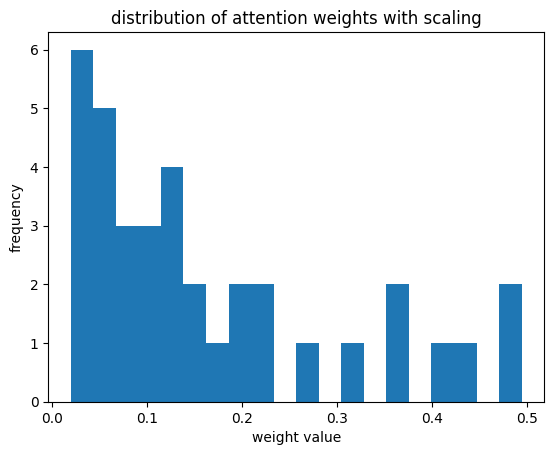

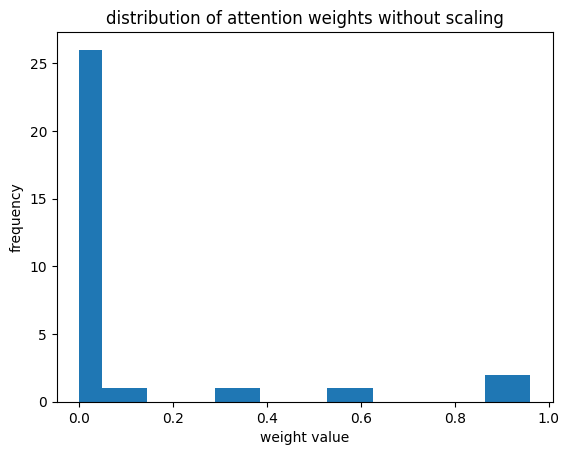

In [ ]:
# Experiment: compare attention weights with and without scaling
import matplotlib.pyplot as plt

# Create random Q and K for a single batch and sequence
B, T, d_head = 1, 6, 16
q_exp = torch.randn(B, T, d_head)
k_exp = torch.randn(B, T, d_head)

# compute the raw scores
scores_raw = q_exp @ k_exp.transpose(-2, -1)

#add scaling
weights_scaled = torch.softmax(scores_raw / math.sqrt(d_head), dim=-1)

#without scaling
weights_without_scale = torch.softmax(scores_raw, dim=-1)

#Compute the statistics
def describe(weights, name):
    mean = weights.mean().item()
    std = weights.std().item()
    print(f"{name} -> mean: {mean:.4f}, std: {std:.4f}")

describe(weights_scaled, 'with scaling')
describe(weights_without_scale, 'without scaling')

flat_scaled = weights_scaled.view(-1).detach().numpy()
flat_no_scale = weights_without_scale.view(-1).detach().numpy()

plt.hist(flat_scaled, bins=20)
plt.title('distribution of attention weights with scaling')
plt.xlabel('weight value')
plt.ylabel('frequency')
plt.show()

plt.hist(flat_no_scale, bins=20)
plt.title('distribution of attention weights without scaling')
plt.xlabel('weight value')
plt.ylabel('frequency')
plt.show()

Without scaling, the distribution of attention weights becomes more peaked (higher variance), meaning one or two tokens dominate the attention. The scaling results in a more balanced distribution, allowing the model to consider multiple relevant tokens instead of focusing narrowly.

Now, we will add a casual mask so that each token can only attend to itself and tokens to its left. This is essential for language models that predict the next token, because they must not peek at future tokens during training. 

attention weights with casual mask (shape): torch.Size([1, 6, 6])


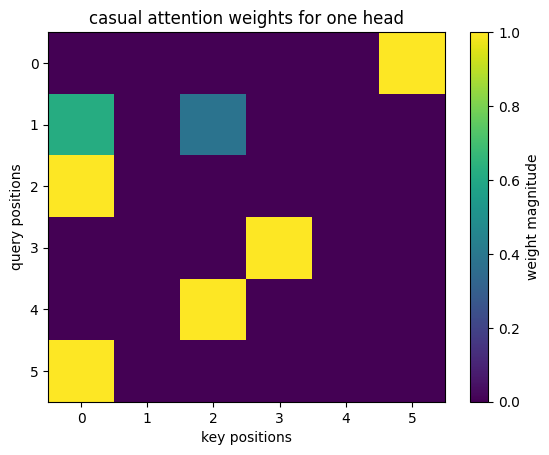

In [7]:
# Demo of casual masking
import matplotlib.pyplot as plt


B, T, d_model, d_head = 1, 6, 32, 16
x_mask = torch.randn(B, T, d_model)

W_Q_mask = torch.randn(d_model, d_head)
W_K_mask = torch.randn(d_model, d_head)
W_V_mask = torch.randn(d_model, d_head)

q_mask = x_mask @ W_Q_mask
k_mask = x_mask @ W_K_mask
v_mask = x_mask @ W_V_mask

scores_mask = q_mask @ k_mask.transpose(-2, -1) / math.sqrt(d_head)

mask = torch.tril(torch.ones(T, T)).bool()

scores = scores_mask.masked_fill(~mask, float('-inf'))

weights_masked = torch.softmax(scores_mask, dim=-1)
out_masked = weights_masked @ v_mask

print('attention weights with casual mask (shape):', weights_masked.shape)

#visualize the masked attention weights matrix
plt.imshow(weights_masked[0].detach(), aspect='auto')
plt.title('casual attention weights for one head')
plt.xlabel('key positions')
plt.ylabel('query positions')
plt.colorbar(label='weight magnitude')
plt.show()

Notice how the attention matrix above is lower triangular - positions on the diagonal and below have non-zero weights, while positions above the diagonal are forced to zero. This prevents the model from attending to future tokens. 

# Multi-Head Self-Attention

a single attention head might focus on one type of relationship (for example, matching nouns to verbs). In practice we run several attention heads in parallel, each with its own set of (W_Q, W_K, W_V). Each head can specialize in different patterns or scales of the data. 

After computing the attention outputs for each head, we concatenate them and apply a final linear projection. 

In [10]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model: int, n_heads: int):
        super().__init__()
        assert d_model % n_heads == 0 # d_model must be divisible by n_heads
        self.n_heads = n_heads
        self.d_head = d_model // n_heads
        self.qkv_proj = nn.Linear(d_model, 3 * d_model)
        self.out_proj = nn.Linear(d_model, d_model)

    def forward(self, x: torch.Tensor, casual: bool=True):
        B, T, C = x.shape
        # compute QKV and split into separate tensors
        qkv = self.qkv_proj(x)
        q, k, v = torch.chunk(qkv, chunks=3, dim=-1)

        #reshape to (B, n_heads, T, d_head)
        q = q.view(B, T, self.n_heads, self.d_head).transpose(1, 2)
        k = k.view(B, T, self.n_heads, self.d_head).transpose(1, 2)
        v = v.view(B, T, self.n_heads, self.d_head).transpose(1, 2)

        #scaled dot-product attention for each head
        scores = q @ k.transpose(-2, -1) / math.sqrt(self.d_head) 
        if casual:
            mask = torch.tril(torch.ones(T, T, device = x.device)).bool()
            scores = scores.masked_fill(~mask, float('inf'))
        weights = torch.softmax(scores, dim=-1)
        attn_output = weights @ v 

        # concatenate heads and project
        attn_output = attn_output.transpose(1, 2).contiguous().view(B, T, C)
        output = self.out_proj(attn_output)
        return output, weights

#Demo 
B, T, d_model, n_heads = 2, 5, 16, 4
x_demo = torch.randn(B, T, d_model)

mha = MultiHeadSelfAttention(d_model=d_model, n_heads=n_heads)

out_mha, weights_mha = mha(x_demo, casual=True)

print('output shape from multi-head attention', out_mha.shape)
print('attention weights shape:', weights_mha.shape)


output shape from multi-head attention torch.Size([2, 5, 16])
attention weights shape: torch.Size([2, 4, 5, 5])


The output has the same shape as the input (batch, sequence, d_model). The attention weights tensor has shape (batch, n_heads, sequence, sequence) - each head has its own attention matrix.

Head 0: sharpness 0.0265
Head 1: sharpness 0.0316
Head 2: sharpness 0.0358
Head 3: sharpness 0.0301


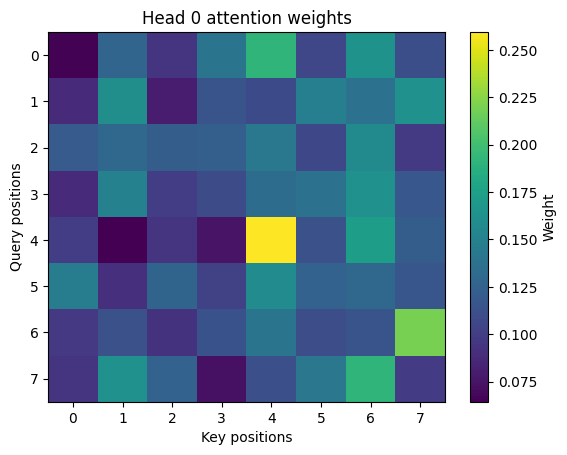

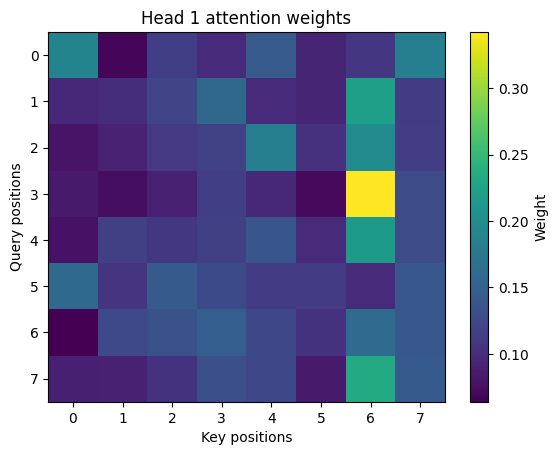

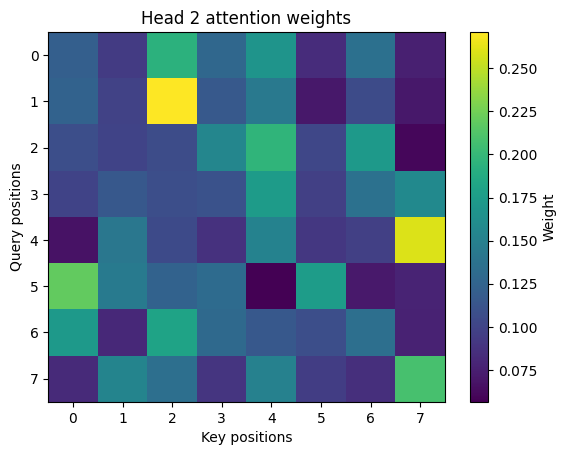

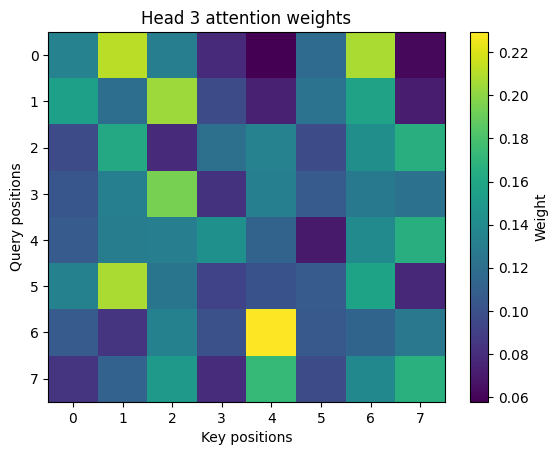

In [12]:
# Now we will measure attention sharpness for each head using the mean absolute deviation from uniform distribution 

B, T, d_model, n_heads = 1, 8, 32, 4
x_rand = torch.randn(B, T, d_model)

mha_test = MultiHeadSelfAttention(d_model=d_model, n_heads=n_heads)

_, weights_test = mha_test(x_rand, casual=False)

uniform = 1.0 / T
sharpness_per_head = []
for h in range(n_heads):
    # weights_test shape: (B, n_heads, T, T)
    w = weights_test[0, h]  # (T, T)
    # Deviation from uniform across each row
    deviation = torch.abs(w - uniform).mean(dim=-1)  # mean deviation per query position
    sharpness = deviation.mean().item()
    sharpness_per_head.append(sharpness)

for h, s in enumerate(sharpness_per_head):
    print(f"Head {h}: sharpness {s:.4f}")

# Plot the attention matrices for each head (one at a time)
for h in range(n_heads):
    plt.imshow(weights_test[0, h].detach(), aspect='auto')
    plt.title(f'Head {h} attention weights')
    plt.xlabel('Key positions')
    plt.ylabel('Query positions')
    plt.colorbar(label='Weight')
    plt.show()

The printed **sharpness** values give a rough idea of how each head distributes its attention.  Higher numbers mean the head focuses more narrowly on a few positions.  By visualizing the attention matrices for each head, you can see different patterns — some heads might attend mostly to nearby tokens, while others attend more broadly.